In [54]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [33]:
with open('/content/BTC_hist_daily_prices.json') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
df = df.drop(['conversionType', 'conversionSymbol'], axis=1 )
target_col = 'close'

df.head(100)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,20.00,0.9902,0.04951
2010-07-18,0.08585,0.05941,0.04951,75.01,5.0920,0.08584
2010-07-19,0.09307,0.07723,0.08584,574.00,49.6600,0.08080
2010-07-20,0.08181,0.07426,0.08080,262.00,20.5900,0.07474
2010-07-21,0.07921,0.06634,0.07474,575.00,42.2600,0.07921
...,...,...,...,...,...,...
2010-10-20,0.10300,0.09400,0.09700,31855.00,3221.0800,0.09900
2010-10-21,0.10900,0.09700,0.09900,44867.00,4616.8500,0.10700
2010-10-22,0.10900,0.10150,0.10700,34603.91,3665.4300,0.10250


In [34]:
# Normalize values between 0-1 for every feature (each column is divided by column max value).

scaler = MinMaxScaler()
array_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(array_scaled, columns=df.columns,index=df.index)
df_scaled.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.000000,0.000002,0.000000,0.000035,1.585403e-10,0.000000
2010-07-18,0.000002,0.000003,0.000000,0.000131,8.152768e-10,0.000002
2010-07-19,0.000002,0.000004,0.000002,0.001003,7.951030e-09,0.000002
2010-07-20,0.000002,0.000003,0.000002,0.000458,3.296651e-09,0.000001
2010-07-21,0.000001,0.000003,0.000001,0.001005,6.766221e-09,0.000002


In [35]:
# Splits and shuffles the dataset into train, validation and test sets.

def train_val_test_split(df, validation_size=0.15, test_size=0.1):
    return np.split(df, [int((1-validation_size)*len(df)), int((1-test_size)*len(df))]) 

train_orig, valid_orig, test_orig = train_val_test_split(df)
train, validation, test = train_val_test_split(df_scaled)




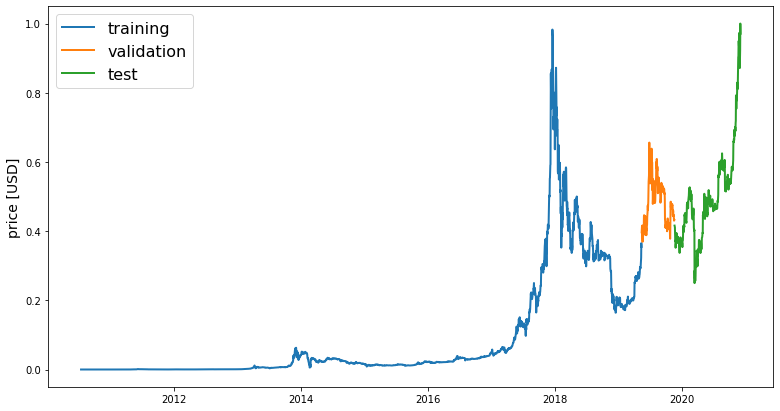

In [55]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train[target_col], validation[target_col], test[target_col], 'training', 'validation', 'test', title='')

In [36]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10):
    train_data, validation_data, test_data = train_val_test_split(df)
    X_train = extract_window_data(train_data, window_len)
    X_val = extract_window_data(validation_data, window_len)
    X_test = extract_window_data(test_data, window_len)
    y_train = train_data[target_col][window_len:].values
    y_val = validation_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values

    return X_train, X_val, X_test, y_train, y_val, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [73]:
np.random.seed(42)
window_len = 5
lstm_neurons = 100
epochs = 200
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [74]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [75]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_scaled, target_col, window_len=window_len)

In [76]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, callbacks=[])

Epoch 1/200
101/101 [==============================] - 2s 9ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 2/200
101/101 [==============================] - 0s 4ms/step - loss: 4.5908e-04 - val_loss: 0.0012
Epoch 3/200
101/101 [==============================] - 0s 3ms/step - loss: 4.3814e-04 - val_loss: 0.0017
Epoch 4/200
101/101 [==============================] - 0s 4ms/step - loss: 4.5930e-04 - val_loss: 0.0027
Epoch 5/200
101/101 [==============================] - 0s 3ms/step - loss: 3.4715e-04 - val_loss: 0.0017
Epoch 6/200
101/101 [==============================] - 0s 3ms/step - loss: 4.1582e-04 - val_loss: 0.0013
Epoch 7/200
101/101 [==============================] - 0s 4ms/step - loss: 3.1359e-04 - val_loss: 8.5121e-04
Epoch 8/200
101/101 [==============================] - 0s 3ms/step - loss: 3.5935e-04 - val_loss: 7.7864e-04
Epoch 9/200
101/101 [==============================] - 0s 3ms/step - loss: 3.0676e-04 - val_loss: 7.0214e-04
Epoch 10/200
101/101 [=========================

In [69]:
preds = model.predict(X_test).squeeze()

arr = np.zeros([preds.shape[0], 6])
arr[:, 5] = preds

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res, columns=df.columns)

df_res.head()

,high,low,open,volumefrom,volumeto,close
0,0.04951,0.01,0.04951,0.0,0.0,7170.562085
1,0.04951,0.01,0.04951,0.0,0.0,7012.907030
2,0.04951,0.01,0.04951,0.0,0.0,6859.232822
3,0.04951,0.01,0.04951,0.0,0.0,6762.936795
4,0.04951,0.01,0.04951,0.0,0.0,6836.248341


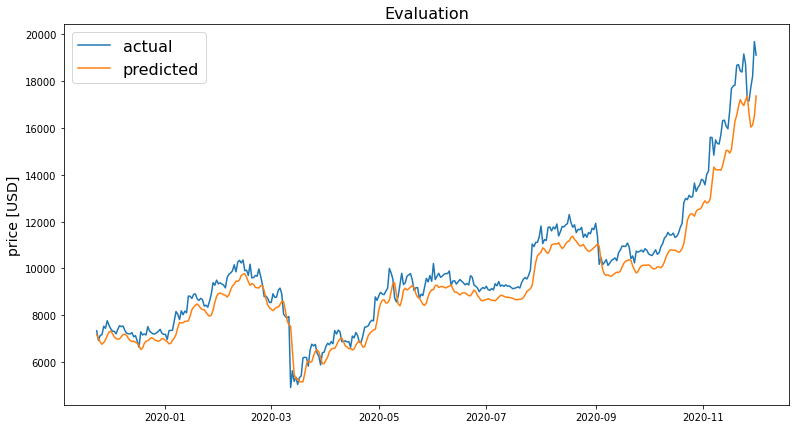

In [72]:
predicted_closing_prices = df_res[target_col].values
actual_closing_prices = test_orig[target_col][window_len:]
predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(actual_closing_prices, label='actual')
ax.plot(predicted_closing_prices, label='predicted')
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Evaluation', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()